In [1]:
"""def intersect_trop_lines(assumptions, first,second):
    a = first[0]
    b = first[1]
    c = second[0]
    d = second[1]
    #anchored at (c,d)
    if a>c and b>d and a>b: #1
        return [c+b,d+b]
    if a>c and b>d and a<b: #2
        return [c+a,d+a]
    if a>c and b>d and a==b:
        return [c+b-d,b]
    if a<c and b>d: #3
        return [a,d]
    if a<c and b<d and a<b: #4
        return [a+d-b,d]
    if a<c and b<d and a>b: #5
        return [c,b+c-a]
    if a<c and b<d and a==b:
        return [c,b+c-a]
    if a>c and d>b: #6
        return [c,b]
    #anchored at (a,b)
    if c>a and d>b and c>d: #1
        return [a+d,b+d]
    if c>a and d>b and c<d: #2
        return [a+c,b+c]
    if c>a and d>b and c==d:
        return [a+d-b,d]
    if c<a and d>b: #3
        return [c,b]
    if c<a and d<b and c<d: #4
        return [c+b-d,b]
    if c<a and d<b and c>d: #5
        return [a,d+a-c]
    if c<a and d<b and c==d:
        return [a,d+a-c]
    if c>a and b>d: #6
        return [a,d]
    
    
def polytron(assumptions, vertices):
    pseudovertices = copy(vertices)
    edges = []
    for pair in Subsets(range(len(vertices)),2):
        if intersect_trop_lines(assumptions, vertices[pair[0]],vertices[pair[1]]):
            pseudovertices.append(intersect_trop_lines(vertices[pair[0]],vertices[pair[1]]))
            index = len(pseudovertices)-1
            edges.append([pair[0],index])
            edges.append([pair[1],index])
        else:
            edges.append(list(pair))
    return {'pseudo': pseudovertices, 'edges': edges, 'vertices': vertices}


def tangent_cone(polytron, vertex_index):
    
    def primitive_vector_in_edge_direction(direction):
        x = direction[0]
        y = direction[1]
        if x==0 and y>0:
            primitive = [ 0, 1]
        elif x==0 and y<0:
            primitive = [ 0,-1]
        elif x>0 and y>0:
            primitive = [ 1, 1]
        elif x>0 and y==0:
            primitive = [ 1, 0]
        elif x<0 and y==0:
            primitive = [-1, 0]
        elif x<0 and y<0:
            primitive = [-1,-1]
        else:
            print 'cannot find primitive vector in direction ('+str(x)+' , '+str(y)+')'
        return primitive
    
    ##compute the generating function of the tangent cone at the given vertex
    vertex = polytron['pseudo'][vertex_index]
    
    
    #find neighbours of vertex
    incident_edges_index = [edge for edge in polytron["edges"] if vertex_index in edge]
    neighbours_index = []
    for edge_index in incident_edges_index:
        for index in edge_index:
            if index==vertex_index:
                continue
            else:
                neighbours_index.append(index)    
    neighbours = [ polytron['pseudo'][index] for index in neighbours_index ]
    
    #compute edge-directions
    edge_directions = [ [neighbour[0]-vertex[0],neighbour[1]-vertex[1]] for neighbour in neighbours ]
    
    primitives=[]
    #find primitive vector in edge-direction
    for direction in edge_directions:
        primitives.append(primitive_vector_in_edge_direction(direction))
    
    
    t1, t2, n = var('t1, t2, n')
    return ( t1^(n*vertex[0])* t2^(n*vertex[1]) )  / ( (1 - t1^primitives[0][0] * t2^primitives[0][1]) * (1 - t1^primitives[1][0] * t2^primitives[1][1])  )

def gen_fct(polytron):
    return sum([tangent_cone(polytron,vertex_index) for vertex_index in range(len(polytron["pseudo"]))])

def ehrhart(polytron,evaluation):
    solutions = [gen_fct(polytron)(a=evaluation[0],b=evaluation[1]).factor()(n=k).factor()(t1=1,t2=1) for k in range(1,4)]
    mat = matrix([ [1,1,1],
                   [4,2,1],
                   [9,3,1] ])
    coeffs = mat.solve_right(vector(solutions))
    t = var('t')
    return sum(coeffs[i]*t^(2-i) for i in range(3))
        
"""

We identify symbolic inequalities by the respective vector, 
e.g. we identify $a - c > 0$ with [0, 1, 0,-1, 0, 0, 0].
The feasible region for a list of assumption is then (the interior of) a polehedral cone $P$ which is defined by
the huperplanes orthogonal to these vectors. If we want to test if another symbolic inequality is valid, 
we can consider the intersection of the Halfspace $H$ orthogonal to the respective inequality and $P$.
If both the assumptions and the inequality in question are strict, then it is valid iff $\text{int} P\subseteq\text{int}H$,

In [136]:
def is_valid_strict(assumptions, question):
    #checks if a strict inequality (question) is satified under the assumptions of other strict inequalities
    #this is not satisfied if intP interected with H_c is nonempty
    P = Polyhedron(ieqs = assumptions)
    #complement of halfspace defined by strict inequality in question
    H_c = Polyhedron(ieqs = [[-i for i in question]]) 
    if len(H_c.intersection(P).vertices())==0:
        return true
    else:
        for F in P.faces(5):
            if H_c.intersection(F.as_polyhedron()) == H_c.intersection(P):
                return true
    return false

def is_valid_nonstrict(assumptions, question):
    #checks if a non-strict inequality (question) is satified under the assumptions of other strict inequalities
    #this is satisfied if intP is contained in H. H is closed, so this is equivalent to P contianed in H
    P = Polyhedron(ieqs = assumptions)
    H = Polyhedron(ieqs = [question]) 
    if H.intersection(P)==P:
        return true
    else:     
        return false

def symbols_to_vector(symbolic_expression):
    symbols_vec = [0,a,b,c,d,e,f]
    string = str(symbolic_expression)
    vec = [0,0,0,0,0,0,0]
    sign = 1
    if string == "0":
        return vector(vec)
    for letter in string:
        if letter in [" "]:
            continue
        elif letter in ["+"]:
            sign = 1
        elif letter in ["-"]:
            sign = -1
        elif var(letter) in symbols_vec:
            index = symbols_vec.index(var(letter))
            vec[index] = 1*sign
    return vector(vec)

def vector_to_symbols(vec):
    a,b,c,d,e,f = var('a,b,c,d,e,f')
    symbols_vec = vector([0,a,b,c,d,e,f])
    return symbols_vec.dot_product(vector(vec))

def greater(assumptions, vec1, vec2):
    #vec1 > vec2 iff vec1 - vec2 > 0 is valid
    question = vec1 - vec2
    return is_valid_strict(assumptions, question)

def equal(assumptions, vec1, vec2):
    if is_valid_nonstrict(assumptions, vec1 - vec2) and is_valid_nonstrict(assumptions, vec2 - vec1):
        return true
    return false

def minimum(assumptions, ieq1, ieq2):
    question = [ieq1[k] - ieq2[k] for k in range(len(ieq1))]
    if is_valid_nonstrict(assumptions, question):
        return ieq2
    elif is_valid_nonstrict(assumptions, [-i for i in question]):
        return ieq1
    else:
        #WARNING this is wrong! Never do this! TODO
        #return ieq1
        print("cannot decide minimum of "+str(ieq1)+" and "+str(ieq2)+" under assumptions "+str(assumptions))

def intersect_trop_lines(assumptions, first,second):
    #translate symbolic expressions into vectors
    a = symbols_to_vector(first[0])
    b = symbols_to_vector(first[1])
    c = symbols_to_vector(second[0])
    d = symbols_to_vector(second[1])
    ass = assumptions
    res = []
    #anchored at (c,d)
    if greater(ass,a,c) and greater(ass,b,d) and greater(ass,a,b): #1
        res =  [c+b,d+b]
    if greater(ass,a,c) and greater(ass,b,d) and greater(ass,b,a): #2
        res =  [c+a,d+a]
    if greater(ass,a,c) and greater(ass,b,d) and equal(ass,a,b):
        res =  [c+b-d,b]
    if greater(ass,c,a) and greater(ass,b,d): #3
        res =  [a,d]
    if greater(ass,c,a) and greater(ass,d,b) and greater(ass,a,b): #4
        res =  [a+d-b,d]
    if greater(ass,c,a) and greater(ass,b,d) and greater(ass,a,b): #5
        res =  [c,b+c-a]
    if greater(ass,c,a) and greater(ass,b,d) and equal(ass,a,b):
        res =  [c,b+c-a]
    if greater(ass,a,c) and greater(ass,b,d): #6
        res =  [c,b]
    #anchored at (a,b)
    if greater(ass,c,a) and greater(ass,b,d) and greater(ass,c,d): #1
        res =  [a+d,b+d]
    if greater(ass,c,a) and greater(ass,b,d) and greater(ass,d,c): #2
        res =  [a+c,b+c]
    if greater(ass,c,a) and greater(ass,b,d) and equal(ass,c,d):
        res =  [a+d-b,d]
    if greater(ass,a,c) and greater(ass,b,d): #3
        res =  [c,b]
    if greater(ass,a,c) and greater(ass,b,d) and greater(ass,c,d): #4
        res =  [c+b-d,b]
    if greater(ass,a,c) and greater(ass,b,d) and greater(ass,c,d): #5
        res =  [a,d+a-c]
    if greater(ass,a,c) and greater(ass,b,d) and equal(ass,c,d):
        res =  [a,d+a-c]
    if greater(ass,c,a) and greater(ass,b,d): #6
        res =  [a,d]
        
    if len(res):
        return [vector_to_symbols(el) for el in res]
    
    
    
def polytron(assumptions, vertices):
    pseudovertices = copy(vertices)
    edges = []
    for pair in Subsets(range(len(vertices)),2):
        if intersect_trop_lines(assumptions, vertices[pair[0]],vertices[pair[1]]):
            pseudovertices.append(intersect_trop_lines(assumptions, vertices[pair[0]],vertices[pair[1]]))
            index = len(pseudovertices)-1
            edges.append([pair[0],index])
            edges.append([pair[1],index])
        else:
            edges.append(list(pair))
    return {'pseudo': pseudovertices, 'edges': edges, 'vertices': vertices, 'assumptions': assumptions}

def tangent_cone(polytron, vertex_index):
    assumptions = polytron['assumptions']
    
    def primitive_vector_in_edge_direction(assumptions, direction):
        ass = assumptions
        x = symbols_to_vector(direction[0])
        y = symbols_to_vector(direction[1])
        zero = vector([0,0,0,0,0,0,0])
        if equal(ass,x,zero) and is_valid_strict(ass,y):
            primitive = [ 0, 1]
        elif equal(ass,x,zero) and is_valid_strict(ass,[-i for i in y]):
            primitive = [ 0,-1]
        elif is_valid_strict(ass,x) and is_valid_strict(ass,y):
            primitive = [ 1, 1]
        elif is_valid_strict(ass,x) and equal(ass,y,zero):
            primitive = [ 1, 0]
        elif is_valid_strict(ass,[-i for i in x]) and equal(ass,y,zero):
            primitive = [-1, 0]
        elif is_valid_strict(ass,[-i for i in x]) and is_valid_strict(ass,[-i for i in y]):
            primitive = [-1,-1]
        else:
            print 'cannot find primitive vector in direction ('+str(x)+' , '+str(y)+')'
        return primitive
    
    ##compute the generating function of the tangent cone at the given vertex
    vertex = polytron['pseudo'][vertex_index]
    
    
    #find neighbours of vertex
    incident_edges_index = [edge for edge in polytron["edges"] if vertex_index in edge]
    neighbours_index = []
    for edge_index in incident_edges_index:
        for index in edge_index:
            if index==vertex_index:
                continue
            else:
                neighbours_index.append(index)    
    neighbours = [ polytron['pseudo'][index] for index in neighbours_index ]
    
    #compute edge-directions
    edge_directions = [ [neighbour[0]-vertex[0],neighbour[1]-vertex[1]] for neighbour in neighbours ]
    
    primitives=[]
    #find primitive vector in edge-direction
    for direction in edge_directions:
        primitives.append(primitive_vector_in_edge_direction(assumptions, direction))
    
    
    t1, t2, n = var('t1, t2, n')
    return ( t1^(n*vertex[0])* t2^(n*vertex[1]) )  / ( (1 - t1^primitives[0][0] * t2^primitives[0][1]) * (1 - t1^primitives[1][0] * t2^primitives[1][1])  )


def gen_fct(polytron):
    return sum([tangent_cone(polytron,vertex_index) for vertex_index in range(len(polytron["pseudo"]))])


Making the Polyhedral Subdivision of $\mathbb R^d$  for 6 variables

The Setup: 

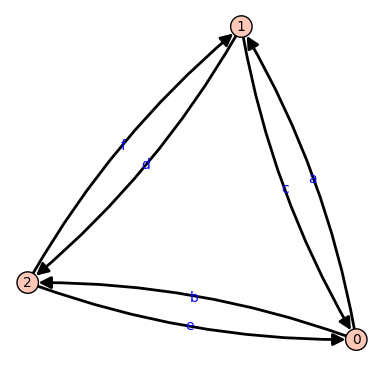

In [137]:
forget()
a,b,c,d,e,f = var('a,b,c,d,e,f')
D = matrix([[0,a,b],[c,0,d],[e,f,0]])
DG = DiGraph(D,weighted = True)
DG.show(edge_labels = True)

Here is the Kleene star of D:
D_Star = $
\begin{pmatrix}
min(0,a+c,b+e) & min(a,a,b+f)   & min(b,a+d,b) \\
min(c,c,d+e)   & min(a+c,0,d+f) & min(c+b,d,d) \\
min(e,f+c,e)   & min(a+e,f,f)   & min(e+b,d+f,0)
\end{pmatrix}$

In [138]:
#(1,1)
H1  = Polyhedron(eqns=[[0,1,0,1,0,0,0]],ieqs=[[0,-1,1,-1,0,1,0]])
H2  = Polyhedron(eqns=[[0,0,1,0,0,1,0]],ieqs=[[0,1,-1,1,0,-1,0]])
#(1,2)
H3  = Polyhedron(ieqs=[[0,-1,1,0,0,0,1]])
#(1,3)
H4  = Polyhedron(ieqs=[[0,1,-1,0,1,0,0]])
#(2,1)
H5  = Polyhedron(ieqs=[[0,0,0,-1,1,1,0]])
#(2,2)
H6  = Polyhedron(eqns=[[0,1,0,1,0,0,0]],ieqs=[[0,0,0,0,1,0,1]])
H7  = Polyhedron(eqns=[[0,0,0,0,1,0,1]],ieqs=[[0,1,0,1,0,0,0]])
#(2,3)
H8  = Polyhedron(ieqs=[[0,0,1,1,-1,0,0]])
#(3,1)
H9  = Polyhedron(ieqs=[[0,0,0,1,0,-1,1]])
#(3,2)
H10 = Polyhedron(ieqs=[[0,1,0,0,0,1,-1]])
#(3,3)
H11 = Polyhedron(eqns=[[0,0,1,0,0,1,0]],ieqs=[[0,0,0,0,1,0,1]])
H12 = Polyhedron(eqns=[[0,0,0,0,1,0,1]],ieqs=[[0,0,1,0,0,1,0]])

Redoing the Hyperplanes as regions

In [139]:
#(1,1)
R1   = Polyhedron(ieqs = [[0,-1,1,-1,0,1,0],[0,-1,0,-1,0,0,0]])
R2   = Polyhedron(ieqs = [[0,1,0,1,0,0,0],[0,0,1,0,0,1,0]])
R3   = Polyhedron(ieqs = [[0,0,-1,0,0,-1,0],[0,1,-1,1,0,-1,0]])
F11  = [R1,R2,R3]
#(1,2)
R4   = Polyhedron(ieqs = [[0,-1,1,0,0,0,1]])
R5   = Polyhedron(ieqs = [[0,1,-1,0,0,0,-1]])
F12  = [R4,R5]
#(1,3)
R6   = Polyhedron(ieqs = [[0,1,-1,0,1,0,0]])
R7   = Polyhedron(ieqs = [[0,-1,1,0,-1,0,0]])
F13  = [R6,R7]
#(2,1)
R8   = Polyhedron(ieqs = [[0,0,0,-1,1,1,0]])
R9   = Polyhedron(ieqs = [[0,0,0,1,-1,-1,0]])
F21  = [R8,R9]
#(2,2)
R10  = Polyhedron(ieqs = [[0,-1,0,-1,1,0,1],[0,-1,0,-1,0,0,0]])
R11  = Polyhedron(ieqs = [[0,0,0,0,1,0,1],[0,1,0,1,0,0,0]])
R12  = Polyhedron(ieqs = [[0,0,0,0,-1,0,-1],[0,1,0,1,-1,0,-1]])
F22  = [R10,R11,R12]
#(2,3)
R13  = Polyhedron(ieqs = [[0,0,1,1,-1,0,0]])
R14  = Polyhedron(ieqs = [[0,0,-1,-1,1,0,0]])
F23  = [R13,R14]
#(3,1)
R15  = Polyhedron(ieqs = [[0,0,0,1,0,-1,1]])
R16  = Polyhedron(ieqs = [[0,0,0,-1,0,1,-1]])
F31  = [R15,R16]
#(3,2)
R17  = Polyhedron(ieqs = [[0,1,0,0,0,1,-1]])
R18  = Polyhedron(ieqs = [[0,-1,0,0,0,-1,1]])
F32  = [R17,R18]
#(3,3)
R19  = Polyhedron(ieqs = [[0,0,-1,0,1,-1,1],[0,0,-1,0,0,-1,0]])
R20  = Polyhedron(ieqs = [[0,0,1,0,0,1,0],[0,0,0,0,1,0,1]])
R21  = Polyhedron(ieqs = [[0,0,1,0,-1,1,-1],[0,0,0,0,-1,0,-1]])
F33  = [R19,R20,R21]

Find the feasible, full dimensional regions:

In [140]:
def regions_of_complex(polyhedral_complex):
    r"""
    Returns the feasible regions of the ``polyhedral_complex``.
    Follows the method of regions in the hyperplane arrangements.
    
    INPUT: 
    
    - ``polyhedral_complex`` -- list. A list of polyhedron objects
    
    OUTPUT:
    
    A tuple of regions.
    """
    R = polyhedral_complex[0][0].base_ring()
    universe = Polyhedron(eqns = [[0] + [0]*6],base_ring = R)
    regions = [universe]
    for fan in polyhedral_complex:
        subdivided = []
        for region in regions:
            for cone in fan:
                part = region.intersection(cone)
                if part.dim()==6:
                    subdivided.append(part)
        regions = subdivided
    return tuple(regions)

Test it on the fans

In [141]:
six_variables_complex = [F11,F12,F13,F21,F22,F23,F31,F32,F33]
regions = regions_of_complex(six_variables_complex)

In [142]:
len(regions)

117

Discard the infeasible regions

In [143]:
def feasible_regions(initial_regions):
    r"""
    From the regions of a polyhedral complex, return the feasible regions.
    
    INPUT:
    
    -  ``initial_regions`` -- tuple of polyhedron objects. 
    
    OUTPUT:
    
    tuple of polyhedron objects representiing the feasible regions.
    """

    final_regions = list(initial_regions)
    q1 = [0,-1, 0,-1, 0, 0, 0]
    q2 = [0, 0,-1, 0, 0,-1, 0]
    q3 = [0, 0, 0, 0,-1, 0,-1]
    for region in initial_regions:
        assumptions = region.inequalities_list()
        if is_valid_strict(assumptions, q1) or is_valid_strict(assumptions, q2) or is_valid_strict(assumptions, q3):
            final_regions.remove(region)
    return final_regions

In [144]:
feas_regs = feasible_regions(regions)

In [145]:
len(feas_regs)

18

In [146]:
first_region= regions[0]
first_region.inequalities_list()

[[0, 1, -1, 0, 1, 0, 0],
 [0, -1, 1, -1, 0, 1, 0],
 [0, 0, -1, 0, 0, -1, 0],
 [0, 0, 0, 1, 0, -1, 1]]

Try to get the Ehrhart polynomial for ``first_region``
These inequalities imply the following kleene star:
D_star_one = 
$\begin{pmatrix}
a+c & a & b \\
c & a+c & c+b \\
e  & a + e & b+e
\end{pmatrix}$

In [147]:
feas_regs[0].inequalities_list()

[[0, -1, 1, 0, 0, 0, 1],
 [0, 0, 0, -1, 1, 1, 0],
 [0, 1, 0, 0, 0, 1, -1],
 [0, 0, 0, 1, 0, -1, 1],
 [0, 1, -1, 0, 1, 0, 0],
 [0, 0, 1, 1, -1, 0, 0]]

In [148]:
def tropical_vertices_from_region(region):
    r"""
    Return the symbolic tropical vertices corresponding to 
    a certain region. 
    
    INPUT:
    
    - ``region`` -- a polyhedron object. 
    
    OUTPUT:
    
    A list of the tropical vertices (already in the plane). 
    """

    assumptions = region.inequalities_list()
    zero = vector([0, 0, 0, 0, 0, 0, 0])
    a = vector([0, 1, 0, 0, 0, 0, 0])
    b = vector([0, 0, 1, 0, 0, 0, 0])
    c = vector([0, 0, 0, 1, 0, 0, 0])
    d = vector([0, 0, 0, 0, 1, 0, 0])
    e = vector([0, 0, 0, 0, 0, 1, 0])
    f = vector([0, 0, 0, 0, 0, 0, 1])
    K = [ [zero,                       minimum(assumptions, a,b+f), minimum(assumptions,a+d,b)],
          [minimum(assumptions,c,d+e), zero,                        minimum(assumptions,c+b,d)],
          [minimum(assumptions,f+c,e), minimum(assumptions, a+e,f), zero                      ]]
    a,b,c,d,e,f = var('a,b,c,d,e,f')
    symbols_vec = vector([0,a,b,c,d,e,f])
    Kleene = []
    for row in K:
        Kleene.append([ symbols_vec.dot_product(entry) for entry in row ])
    Kleene = matrix(Kleene)
    #subtract the first entry
    L = list()
    for i in range(len(Kleene.rows())):
        new_row = list()
        j = Kleene.row(i)[0]
        for k in range(1,len(Kleene.row(i))):
            new_row.append(Kleene.row(i)[k] - j)
        L.append(new_row)
    return L

In [149]:
verts = tropical_vertices_from_region(feas_regs[0])
assumptions = feas_regs[0].inequalities_list()
poly = polytron(assumptions, verts)


In [150]:
poly

{'assumptions': [[0, -1, 1, 0, 0, 0, 1],
  [0, 0, 0, -1, 1, 1, 0],
  [0, 1, 0, 0, 0, 1, -1],
  [0, 0, 0, 1, 0, -1, 1],
  [0, 1, -1, 0, 1, 0, 0],
  [0, 0, 1, 1, -1, 0, 0]],
 'edges': [[0, 3], [1, 3], [0, 4], [2, 4], [1, 5], [2, 5]],
 'pseudo': [[a, b],
  [-c, -c + d],
  [-e + f, -e],
  [-c, b],
  [-e + f, b],
  [-c, -e]],
 'vertices': [[a, b], [-c, -c + d], [-e + f, -e]]}

In [151]:
generating_f = gen_fct(poly).factor()

In [152]:
print generating_f

(t1^(a*n + c*n + e*n + 2)*t2^(b*n + c*n + e*n + 2) - t1^(c*n + f*n + 1)*t2^(b*n + c*n + e*n + 2) + t1^(c*n + f*n)*t2^(b*n + c*n + e*n + 2) - t1^(e*n + 1)*t2^(b*n + c*n + e*n + 2) + t1^(e*n)*t2^(b*n + c*n + e*n + 2) - 2*t1^(a*n + c*n + e*n + 2)*t2^(b*n + c*n + e*n + 1) + t1^(c*n + f*n + 1)*t2^(b*n + c*n + e*n + 1) - t1^(c*n + f*n)*t2^(b*n + c*n + e*n + 1) + t1^(e*n + 1)*t2^(b*n + c*n + e*n + 1) - t1^(e*n)*t2^(b*n + c*n + e*n + 1) + t1^(a*n + c*n + e*n + 2)*t2^(b*n + c*n + e*n) - t1^(c*n + f*n + 2)*t2^(c*n + 1) + t1^(c*n + f*n + 1)*t2^(c*n + 1) + t1^(e*n + 1)*t2^(c*n + 1) - t1^(e*n)*t2^(c*n + 1) + t1^(c*n + f*n + 2)*t2^(c*n) - t1^(c*n + f*n + 1)*t2^(c*n) - t1^(e*n + 1)*t2^(c*n) + t1^(e*n)*t2^(c*n) - t1^(e*n + 2)*t2^(d*n + e*n + 1) + 2*t1^(e*n + 1)*t2^(d*n + e*n + 1) - t1^(e*n)*t2^(d*n + e*n + 1))*t1^(-c*n - e*n)*t2^(-c*n - e*n)/((t1 - 1)^2*(t2 - 1)^2)


Try to compute the generating function for all feasible regions. So far, this works for all but region 12 and 16:

In [155]:
count = -1
generating_fcts = []
for region in feas_regs:
    verts = tropical_vertices_from_region(region)
    assumptions = region.inequalities_list()
    poly = polytron(assumptions, verts)
    count += 1
    try:
        generating_f = gen_fct(poly).factor()
        generating_fcts.append(generating_f)
    except:
        print 'impossible to compute generating function for region '+str(count)
        continue
    

cannot find primitive vector in direction ((0, -1, 0, 0, -1, -1, 0) , (0, -1, 0, 0, -1, -1, 0))
impossible to compute generating function for region 12
cannot find primitive vector in direction ((0, 0, -1, -1, 0, 0, -1) , (0, 0, 0, 0, 0, 0, 0))
impossible to compute generating function for region 16


Replace all variables by $(1-t)$ and apply l'hopital in order to evaluate the generating function at $(1,\dots,1)$:

In [156]:
def lhopital(generating_f):
    #substitute all variables by (1-t)
    t = var('t')
    for j in range(1,3):
         generating_f = generating_f.subs({var('t'+str(j)):1-t})
        #generating_f = generating_f.subs({var('t'+str(j)):1-j*t})
    
    #l'hopital
    p = generating_f.numerator()
    q = generating_f.denominator()
    alpha = 0
    p_deriv= p
    q_deriv = q
    while true:
        p_deriv = p_deriv.derivative(t)
        q_deriv = q_deriv.derivative(t)
        alpha += 1
        if not (p_deriv(t=0)==0 or q_deriv(t=0)==0):
            break
    return p_deriv(t=0)/q_deriv(t=0)

Evaluate the generating functions of all regions but 12 and 16 at $(1,\dots,1)$:

In [157]:
multivariate_ehrhart = []
for generating_f in generating_fcts:
    multivariate_ehrhart.append(lhopital(generating_f).simplify_full())

In [158]:
multivariate_ehrhart

[1/2*(a^2 + 2*a*b - b^2 + 2*b*c - 4*c^2 + 4*c*d - d^2 + 2*(b + c)*e - 4*e^2 - 2*(b - 3*e)*f - 2*f^2)*n^2 + 1/2*(3*a + b + 4*c - d + 4*e - 2*f)*n + 1,
 1/2*(2*a*b + 2*b*c - c^2 + 2*c*d - d^2 + 2*(a + c)*e)*n^2 + 1/2*(2*a + 2*b + 3*c - d + 2*e)*n + 1,
 1/2*(a^2 + 2*a*b - b^2 + 2*(a + b)*c + c^2 + 2*c*d - d^2 + 2*c*f + f^2)*n^2 + 1/2*(3*a + b + 5*c - d + f)*n + 1,
 1/2*(a^2 + 2*a*b - b^2 + 2*b*c + 2*(a + c)*e - e^2 - 2*(b - e)*f - 2*f^2)*n^2 + 1/2*(3*a + b + 2*c + 3*e - 2*f)*n + 1,
 (a*b + b*c + (a + c)*e)*n^2 + (a + b + c + e)*n + 1,
 1/2*(a^2 + 2*a*b - b^2 + 2*(a + b)*c + 2*c^2 + 2*c*f + f^2)*n^2 + 1/2*(3*a + b + 4*c + f)*n + 1,
 1/2*(a^2 + 2*a*b - b^2 + 2*b*d + 2*(a + b + d)*e + e^2 - 2*(b - e)*f - 2*f^2)*n^2 + 1/2*(3*a + b + 2*d + 5*e - 2*f)*n + 1,
 (a*b + b*d + (a + b + d)*e + e^2)*n^2 + (a + b + d + 2*e)*n + 1,
 (a^2 + a*c - 2*c^2 + 3*c*d - d^2 + (a + c + d)*e - 2*e^2 - (a + d - 3*e)*f - f^2)*n^2 + (2*a + 2*c + 2*e - f)*n + 1,
 1/2*(2*a^2 + 2*a*c - c^2 + 2*(a + 2*c)*d - d^2 + 2*(a +

old stuff

Extend the list of assumptions by adding pairs of assumptions of the form $2a + b - c > 0, c + d > 0$ to $2a + b + d > 0$

In [8]:
import re
def extend_assumptions(integer):
    #integer is the number of rounds in which we combine each pair
    for i in range(integer):
        #extract all inequalities
        #assuming that all inequalities are of the form "2a+b-c>0"
        pos_str = []
        for assumption in assumptions():
            asstr = str(assumption)
            if re.search(" > 0", asstr):
                pos_str.append(re.split(" > ", asstr)[0])

        #try to add combined assumptions
        for term1 in pos_str:
            for term2 in pos_str:
                try:
                    eval('assume('+term1+' + '+term2+' > 0)')
                except:
                    continue   

two variables case

In [ ]:
a, b = var('a, b')
forget(assumptions())
assume( a>-1, -a-3<b, -b - 2<0)

vertices = [[b,1],[-a-3,-a],[b,-a]]
polytron = compute_pseudovertices(vertices)
#print polytron

#print gen_fct(polytron).numerator_denominator() 
generating_f = gen_fct(polytron).factor()
print generating_f
ehrhart(polytron,[0,0])

In [38]:
#substitute all variables by (1-t)
t = var('t')
for j in range(1,3):
     generating_f = generating_f.subs({var('t'+str(j)):1-t})
    #generating_f = generating_f.subs({var('t'+str(j)):1-j*t})
print generating_f

((t - 1)*(-t + 1)^(a*n + b*n + 3*n + 2) + (-t + 1)^(a*n + b*n + 3*n + 2)*(-t + 1)^(a*n + n + 2) - (-t + 1)^(a*n + b*n + 3*n + 1)*(-t + 1)^(a*n + n + 1) - (-t + 1)^(a*n + n + 2)*(-t + 1)^(a*n + n + 1) - t + (-t + 1)^(2*a*n + 2*n + 2) + (-t + 1)^(a*n + b*n + 3*n + 1))*(-t + 1)^(-a*n - 3*n)/(((t - 1)^2 - 1)*t^2*(-t + 1)^(a*n))


In [39]:
#l'hopital
p = generating_f.numerator()
q = generating_f.denominator()
alpha = 0
p_deriv= p
q_deriv = q
while true:
    p_deriv = p_deriv.derivative(t)
    q_deriv = q_deriv.derivative(t)
    alpha += 1
    if not (p_deriv(t=0)==0 or q_deriv(t=0)==0):
        break
result = p_deriv(t=0)/q_deriv(t=0)
print result.simplify_full()

1/2*(a^2 + 2*(a + 1)*b + 6*a + 5)*n^2 + 1/2*(3*a + 2*b + 7)*n + 1


In [40]:
result(a=1,b=0).simplify_full()

6*n^2 + 5*n + 1